In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/MLPROJ')
from IPython.display import clear_output as clc

!pip install ftfy regex tqdm fvcore
!pip install git+https://github.com/openai/CLIP.git
!pip install -U --no-cache-dir gdown --pre
!pip install pybullet moviepy
!pip install openai
!pip install easydict
!pip install imageio-ffmpeg
clc()

!pip install -q ultralytics
!pip install -q opencv-python-headless


import collections
import datetime
import random
import threading
import time

import cv2  # Used by ViLD.
import clip
from easydict import EasyDict
import flax
from flax import linen as nn
from flax.training import checkpoints
from flax.metrics import tensorboard
import imageio
from heapq import nlargest
import IPython
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np
import openai
import optax
import pickle
from PIL import Image
import pybullet
import pybullet_data
import tensorflow.compat.v1 as tf
import torch
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import clear_output as clc

try:
  import chess
except:
  !pip install python-chess
  import chess

clc()


if not os.path.exists('ur5e/ur5e.urdf'):
  !gdown --id 1Cc_fDSBL6QiDvNT4dpfAEbhbALSVoWcc
  !gdown --id 1yOMEm-Zp_DL3nItG9RozPeJAmeOldekX
  !gdown --id 1GsqNLhEl9dd4Mc3BM0dX3MibOI1FVWNM
  !unzip ur5e.zip
  !unzip robotiq_2f_85.zip
  !unzip bowl.zip

# ViLD pretrained model weights.
!gsutil cp -r gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2 ./

%load_ext tensorboard

# openai.api_key = openai_api_key

# Show useful GPU info.
!nvidia-smi

# Show if JAX is using GPU.
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/saved_model.pb...
Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/variables/variables.data-00000-of-00001...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://cloud-tpu-checkpoints/detection/projects/vild/colab/image_path_v2/variables/variables.index...
| [3 files][323.7 MiB/323.7 MiB]                                                
Operation completed over 3 objects/323.7 MiB.                                    
/bin/bash: line 1: nvidia-smi: command not found


  print(xla_bridge.get_backend().platform)



cpu


In [ ]:
PICK_TARGETS = {
    # White pieces
    "white King": "e1",
    "white Queen": "d1",
    "white Rook 1": "a1",
    "white Rook 2": "h1",
    "white Knight 1": "b1",
    "white Knight 2": "g1",
    "white Bishop 1": "c1",
    "white Bishop 2": "f1",
    "white Pawn 1": "a2",
    "white Pawn 2": "b2",
    "white Pawn 3": "c2",
    "white Pawn 4": "d2",
    "white Pawn 5": "e2",
    "white Pawn 6": "f2",
    "white Pawn 7": "g2",
    "white Pawn 8": "h2",

    # Black pieces
    "black King": "e8",
    "black Queen": "d8",
    "black Rook 1": "a8",
    "black Rook 2": "h8",
    "black Knight 1": "b8",
    "black Knight 2": "g8",
    "black Bishop 1": "c8",
    "black Bishop 2": "f8",
    "black Pawn 1": "a7",
    "black Pawn 2": "b7",
    "black Pawn 3": "c7",
    "black Pawn 4": "d7",
    "black Pawn 5": "e7",
    "black Pawn 6": "f7",
    "black Pawn 7": "g7",
    "black Pawn 8": "h7",
    }




COLORS = {
    "blue":   (78/255,  121/255, 167/255, 255/255),
    "red":    (255/255,  87/255,  89/255, 255/255),
    "green":  (89/255,  169/255,  79/255, 255/255),
    "yellow": (237/255, 201/255,  72/255, 255/255),
    "orange": (242/255, 142/255,  43/255, 255/255),
    "white": (255/255, 255/255, 255/255, 255/255),
    "black": (40/255, 26/255, 13/255, 255/255)
}

square_size = 0.085
target_z = 0.02
board_size=8
z_height=0.01

start_x = -0.35 + 0.05 + (square_size / 2)
start_y = -0.08 - 0.05 - (square_size / 2)

PLACE_TARGETS = {}

# Board squares
for row in range(8):  # rows 0 to 7 represent ranks 1 to 8
    for col in range(8):  # columns 0 to 7 represent files a to h
        square_name = chr(ord('h') - col) + str(row + 1)
        PLACE_TARGETS[square_name] = [
            start_x + col * square_size,
            start_y - row * square_size,
            target_z
        ]

# Captured piece placement zones
# captured_offset_x = start_x + 8 * square_size + square_size  # Right of board
# captured_offset_y_white = start_y
# captured_offset_y_black = start_y - 5 * square_size  # Below white captures

# for i in range(1):  # Max 16 captured pieces per color
#     PLACE_TARGETS[f'captured white {i+1}'] = [
#         captured_offset_x,
#         captured_offset_y_white - i * 0.5 * square_size,
#         target_z
#     ]
#     PLACE_TARGETS[f'captured black {i+1}'] = [
#         captured_offset_x,
#         captured_offset_y_black - i * 0.5 * square_size,
#         target_z
#     ]




PIXEL_SIZE = 0.00267857
BOUNDS = np.float32([[start_x, start_x+8*square_size], [start_y-8*square_size, start_y], [0, 0.12]])  # X Y Z

TEMPORARY_HOLDING_SPOT_XYZ = np.float32([-0.2, -0.2, 0.02]) # Example: A fixed spot off to the side
CAPTURED_PIECES_ZONE_BASE_XYZ = np.float32([BOUNDS[0, 1] + 0.15, BOUNDS[1, 0], 0.02]) # To the right of board
captured_piece_offset_counter = 0 # To stagger captured pieces

config = {
    'pick': [
        "white King",
        "white Queen",
        "white Rook 1",
        "white Rook 2",
        "white Bishop 1",
        "white Bishop 2",
        "white Knight 1",
        "white Knight 2",
        "white Pawn 1",
        "white Pawn 2",
        "white Pawn 3",
        "white Pawn 4",
        "white Pawn 5",
        "white Pawn 6",
        "white Pawn 7",
        "white Pawn 8",
        "black King",
        "black Queen",
        "black Rook 1",
        "black Rook 2",
        "black Bishop 1",
        "black Bishop 2",
        "black Knight 1",
        "black Knight 2",
        "black Pawn 1",
        "black Pawn 2",
        "black Pawn 3",
        "black Pawn 4",
        "black Pawn 5",
        "black Pawn 6",
        "black Pawn 7",
        "black Pawn 8"
    ]
}


In [ ]:
#@title gripper
class Robotiq2F85:
  """Gripper handling for Robotiq 2F85."""

  def __init__(self, robot, tool):
    self.robot = robot
    self.tool = tool
    pos = [0.1339999999999999, -0.49199999999872496, 0.5]
    rot = pybullet.getQuaternionFromEuler([np.pi, 0, np.pi])
    urdf = "robotiq_2f_85/robotiq_2f_85.urdf"
    self.body = pybullet.loadURDF(urdf, pos, rot)
    self.n_joints = pybullet.getNumJoints(self.body)
    self.activated = False

    # Connect gripper base to robot tool: qui mette un JOINT_FIXED tra robot e gripper
    pybullet.createConstraint(self.robot, tool, self.body, 0, jointType=pybullet.JOINT_FIXED, jointAxis=[0, 0, 0], parentFramePosition=[0, 0, 0], childFramePosition=[0, 0, -0.07], childFrameOrientation=pybullet.getQuaternionFromEuler([0, 0, np.pi / 2]))

    # Set friction coefficients for gripper fingers.
    for i in range(pybullet.getNumJoints(self.body)):
      pybullet.changeDynamics(self.body, i, lateralFriction=10.0, spinningFriction=1.0, rollingFriction=1.0, frictionAnchor=True)

    # Start thread to handle additional gripper constraints.
    self.motor_joint = 1
    self.constraints_thread = threading.Thread(target=self.step)
    self.constraints_thread.daemon = True
    self.constraints_thread.start()

  # Control joint positions by enforcing hard contraints on gripper behavior.
  # Set one joint as the open/close motor joint (other joints should mimic).
  def step(self):
    while True:
      try:
        currj = [pybullet.getJointState(self.body, i)[0] for i in range(self.n_joints)]
        indj = [6, 3, 8, 5, 10]
        targj = [currj[1], -currj[1], -currj[1], currj[1], currj[1]]
        pybullet.setJointMotorControlArray(self.body, indj, pybullet.POSITION_CONTROL, targj, positionGains=np.ones(5))
      except:
        return
      time.sleep(0.001)

  # Close gripper fingers.
  def activate(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=1, force=10)
    self.activated = True

  # Open gripper fingers.
  def release(self):
    pybullet.setJointMotorControl2(self.body, self.motor_joint, pybullet.VELOCITY_CONTROL, targetVelocity=-1, force=10)
    self.activated = False

  # If activated and object in gripper: check object contact.
  # If activated and nothing in gripper: check gripper contact.
  # If released: check proximity to surface (disabled).
  def detect_contact(self):
    obj, _, ray_frac = self.check_proximity()
    if self.activated:
      empty = self.grasp_width() < 0.01
      cbody = self.body if empty else obj
      if obj == self.body or obj == 0:
        return False
      return self.external_contact(cbody)
  #   else:
  #     return ray_frac < 0.14 or self.external_contact()

  # Return if body is in contact with something other than gripper
  def external_contact(self, body=None):
    if body is None:
      body = self.body
    pts = pybullet.getContactPoints(bodyA=body)
    pts = [pt for pt in pts if pt[2] != self.body]
    return len(pts) > 0  # pylint: disable=g-explicit-length-test

  # Check_grasp e Grasp_width assist in determining the effectiveness of a grip
  def check_grasp(self):
    while self.moving():
      time.sleep(0.001)
    success = self.grasp_width() > 0.01
    return success

  def grasp_width(self):
    lpad = np.array(pybullet.getLinkState(self.body, 4)[0])
    rpad = np.array(pybullet.getLinkState(self.body, 9)[0])
    dist = np.linalg.norm(lpad - rpad) - 0.047813
    return dist
  # Check Proximity with other surfaces using ray cast
  def check_proximity(self):
    ee_pos = np.array(pybullet.getLinkState(self.robot, self.tool)[0])
    tool_pos = np.array(pybullet.getLinkState(self.body, 0)[0])
    vec = (tool_pos - ee_pos) / np.linalg.norm((tool_pos - ee_pos))
    ee_targ = ee_pos + vec
    ray_data = pybullet.rayTest(ee_pos, ee_targ)[0]
    obj, link, ray_frac = ray_data[0], ray_data[1], ray_data[2]
    return obj, link, ray_frac

  def stop(self):
        self.running = False
        self.constraints_thread.join()

In [ ]:
#@title pickandplace
class PickPlaceEnv():
  # Environment Initialization: utilizza PyBullet
  def __init__(self):
    self.dt = 1/480
    self.sim_step = 0

    # Configure and start PyBullet.
    # python3 -m pybullet_utils.runServer
    # pybullet.connect(pybullet.SHARED_MEMORY)  # pybullet.GUI for local GUI.
    pybullet.connect(pybullet.DIRECT)  # pybullet.GUI for local GUI.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
    pybullet.setPhysicsEngineParameter(enableFileCaching=0)
    assets_path = os.path.dirname(os.path.abspath(""))
    pybullet.setAdditionalSearchPath(assets_path)
    pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
    pybullet.setTimeStep(self.dt)

    self.home_joints = (np.pi / 2, -np.pi / 2, np.pi / 2, -np.pi / 2, 3 * np.pi / 2, 0)  # Joint angles: (J0, J1, J2, J3, J4, J5).
    self.home_ee_euler = (np.pi, 0, np.pi)  # (RX, RY, RZ) rotation in Euler angles.
    self.ee_link_id = 9  # Link ID of UR5 end effector.
    self.tip_link_id = 10  # Link ID of gripper finger tips.
    self.gripper = None

  # Reset dell'environment
  def reset(self, config):
    pybullet.resetSimulation(pybullet.RESET_USE_DEFORMABLE_WORLD)
    pybullet.setGravity(0, 0, -9.8)
    self.cache_video = []

    # Temporarily disable rendering to load URDFs faster.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 0)

    # Add robot.
    pybullet.loadURDF("plane.urdf", [0, 0, -0.001])
    self.robot_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, 0], flags=pybullet.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    self.ghost_id = pybullet.loadURDF("ur5e/ur5e.urdf", [0, 0, -10])  # For forward kinematics.
    self.joint_ids = [pybullet.getJointInfo(self.robot_id, i) for i in range(pybullet.getNumJoints(self.robot_id))]
    self.joint_ids = [j[0] for j in self.joint_ids if j[2] == pybullet.JOINT_REVOLUTE]

    # Move robot to home configuration.
    for i in range(len(self.joint_ids)):
      pybullet.resetJointState(self.robot_id, self.joint_ids[i], self.home_joints[i])

    # Add gripper.
    if self.gripper is not None:
      while self.gripper.constraints_thread.is_alive():
        self.constraints_thread_active = False
    self.gripper = Robotiq2F85(self.robot_id, self.ee_link_id)
    self.gripper.release()

    # Add workspace.
    plane_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.3, 0.3, 0.001])
    plane_id = pybullet.createMultiBody(0, plane_shape, plane_visual, basePosition=[0, -0.5, 0])
    pybullet.changeVisualShape(plane_id, -1, rgbaColor=[0.2, 0.2, 0.2, 1.0])

    # Create the chess board
    self.create_chess_board()

    # Load objects according to config.
    self.config = config
    self.obj_name_to_id = {}

    # Define how pieces should be placed on the board
    # Using the piece naming format from your config
    piece_placements=PICK_TARGETS.copy()


    # Get list of pieces to place from config
    obj_names = list(self.config["pick"]) if "pick" in self.config else []

    # Process each piece
    for obj_name in obj_names:
        # Get piece type and color
        parts = obj_name.split()
        if len(parts) < 2:
            continue

        color = parts[0]

        piece_type = parts[1]  # "King", "Queen", "Rook", etc.

        # Check if this piece has a designated position
        if obj_name in piece_placements:
            square = piece_placements[obj_name]

            position = PLACE_TARGETS[square].copy()  # use copy to avoid modifying the original

            # Adjust height based on piece type
            if piece_type == "Pawn":
                position[2] += 0.02  # Slight elevation for pawns
            else:
                position[2] += 0.03  # Higher elevation for other pieces



            # Load piece based on type
            object_id = None

            if piece_type == "Queen":
              object_id = pybullet.loadURDF("chess_set/Queen_white/Queen_white.urdf", position)
            elif piece_type == "Rook":
              object_id = pybullet.loadURDF("chess_set/Castle_white/Castle_white.urdf", position)
            elif piece_type == "Knight":
              rotation_quat = pybullet.getQuaternionFromEuler([0, 0, np.pi / 2])
              object_id = pybullet.loadURDF("chess_set/Rook_white/Rook_white.urdf", position,rotation_quat)
            elif piece_type == "King":

              object_id = pybullet.loadURDF("chess_set/king_white/king_white.urdf", position)
            elif piece_type == "Pawn":
              object_id = pybullet.loadURDF("chess_set/pawn_black/pawn_black.urdf", position)
            elif piece_type == "Bishop":
              object_id = pybullet.loadURDF("chess_set/Bishop_white/Bishop_white.urdf", position)

            # Apply color to the piece (if needed)
            if object_id is not None:
                object_color = COLORS[color]
                pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
                self.obj_name_to_id[obj_name] = object_id
        else:
            # For pieces without specific placement, use random positions as in original code
            # Get random position 15cm+ from other objects.
            obj_xyz = np.zeros((0, 3))
            while True:
                rand_x = np.random.uniform(BOUNDS[0, 0] + 0.05, BOUNDS[0, 1] - 0.05)
                rand_y = np.random.uniform(BOUNDS[1, 0] + 0.05, BOUNDS[1, 1] - 0.05)
                rand_xyz = np.float32([rand_x, rand_y, 0.01]).reshape(1, 3)
                if len(obj_xyz) == 0:
                    obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
                    break
                else:
                    nn_dist = np.min(np.linalg.norm(obj_xyz - rand_xyz, axis=1)).squeeze()
                    if nn_dist > 0.08:
                        obj_xyz = np.concatenate((obj_xyz, rand_xyz), axis=0)
                        break

            object_color = COLORS[color]
            object_position = rand_xyz.squeeze()

            # Load appropriate object based on type
            if piece_type == "block":
                object_position[2] = 0
                object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
                object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX, halfExtents=[0.02, 0.02, 0.02])
                object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
            elif piece_type == "bowl":
                object_position[2] = 0
                object_id = pybullet.loadURDF("bowl/bowl.urdf", object_position, useFixedBase=1)
            elif piece_type == "cylinder":
                radius = 0.02
                height = 0.05
                object_shape = pybullet.createCollisionShape(pybullet.GEOM_CYLINDER, radius=radius, height=height)
                object_visual = pybullet.createVisualShape(pybullet.GEOM_CYLINDER, radius=radius, length=height)
                object_id = pybullet.createMultiBody(0.01, object_shape, object_visual, basePosition=object_position)
                object_position[2] = height / 2
            elif piece_type == "Queen":

              object_id = pybullet.loadURDF("chess_set/Queen_white/Queen_white.urdf", object_position)
            elif piece_type == "Rook":
              object_id = pybullet.loadURDF("chess_set/Castle_white/Castle_white.urdf", object_position)
            elif piece_type == "Knight":
              rotation_quat = pybullet.getQuaternionFromEuler([0, 0, np.pi / 2])
              object_id = pybullet.loadURDF("chess_set/Rook_white/Rook_white.urdf", object_position,rotation_quat)
            elif piece_type == "King":
              object_id = pybullet.loadURDF("chess_set/king_white/king_white.urdf", object_position)
            elif piece_type == "Pawn":
              object_id = pybullet.loadURDF("chess_set/pawn_black/pawn_black.urdf", object_position)
            elif piece_type == "Bishop":
              object_id = pybullet.loadURDF("chess_set/Bishop_white/Bishop_white.urdf", object_position)

            # Store the object ID
            if object_id is not None:
                pybullet.changeVisualShape(object_id, -1, rgbaColor=object_color)
                self.obj_name_to_id[obj_name] = object_id

    # Re-enable rendering.
    pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING, 1)

    for _ in range(200):
        pybullet.stepSimulation()
    return self.get_observation()


  ################################# chess board ###############################
  def create_chess_board(self):
    print('making the chess board')

    # Create the chess board
    for row in range(board_size):
        for col in range(board_size):
            # Determine position
            pos_x = start_x + col * square_size
            pos_y = start_y - row * square_size
            position = [pos_x, pos_y, z_height]

            # Determine color (alternating pattern)
            is_white = (row + col) % 2 == 0
            color = [0.91, 0.76, 0.65, 1] if is_white else [0.36, 0.25, 0.20, 1]

            # Create block
            half_extents = [square_size/2, square_size/2, 0.01]  # Flatter for chess squares
            object_shape = pybullet.createCollisionShape(pybullet.GEOM_BOX, halfExtents=half_extents)
            object_visual = pybullet.createVisualShape(pybullet.GEOM_BOX,
                                                      halfExtents=half_extents,
                                                      rgbaColor=color)
            pybullet.createMultiBody(0, object_shape, object_visual, basePosition=position)
  # Joint control
  def servoj(self, joints):
    """Move to target joint positions with position control."""
    pybullet.setJointMotorControlArray(
      bodyIndex=self.robot_id,
      jointIndices=self.joint_ids,
      controlMode=pybullet.POSITION_CONTROL,
      targetPositions=joints,
      positionGains=[0.01]*6)

  # End-effector positioning
  def movep(self, position):
    """Move to target end effector position."""
    joints = pybullet.calculateInverseKinematics(
        bodyUniqueId=self.robot_id,
        endEffectorLinkIndex=self.tip_link_id,
        targetPosition=position,
        targetOrientation=pybullet.getQuaternionFromEuler(self.home_ee_euler),
        maxNumIterations=100)
    self.servoj(joints)


  def get_piece_on_square(self, square_center_xyz, tolerance_radius):
      """
      Checks if a square is occupied by a piece (ignoring Z for occupancy check).
      Returns the name and ID of the piece if so.
      tolerance_radius: Max distance from square_center_xyz (X,Y) for a piece to be considered on it.
      """
      for name, obj_id in self.obj_name_to_id.items():
          # Only consider chess pieces
          if not ("white" in name.lower() or "black" in name.lower()):
              continue
          try:
            pos, _ = pybullet.getBasePositionAndOrientation(obj_id)
            # Calculate 2D distance from piece's (x,y) to square_center_xyz's (x,y)
            dist_sq = (pos[0] - square_center_xyz[0])**2 + (pos[1] - square_center_xyz[1])**2
            if dist_sq < (tolerance_radius)**2:
                return name, obj_id
          except pybullet.error:
            # Object might have been removed in a previous step or concurrently
            # print(f"Debug: pybullet.error accessing {name} in get_piece_on_square. Already removed?")
            pass
      return None, None

  def move_piece_off_board(self, piece_id_to_move, piece_name_to_move):
      """Teleports a piece to a predefined off-board location and updates tracking."""
      # Define an off-board location (example)
      # You might want a more sophisticated system for captured piece locations later
      off_board_x = BOUNDS[0, 1] + 0.2 # Place it to the right of the board
      off_board_y = BOUNDS[1, 0] + (len(self.obj_name_to_id) % 10) * 0.05 # Stagger them slightly
      off_board_z = 0.01 # On the ground plane

      new_base_position = [off_board_x, off_board_y, off_board_z]
      # Get current orientation so it doesn't change, or set a default
      _, current_orientation = pybullet.getBasePositionAndOrientation(piece_id_to_move)

      pybullet.resetBasePositionAndOrientation(piece_id_to_move, new_base_position, current_orientation)
      print(f"STEP: Moved captured piece '{piece_name_to_move}' to off-board location {new_base_position}.")

      # IMPORTANT: While the piece is "off-board", it's still in self.obj_name_to_id.
      # For sync_board_with_simulation to correctly ignore it, get_piece_on_square
      # (or the logic within sync_board_with_simulation) must be robust enough
      # to only consider pieces physically on a chess square.
      # The alternative is to `del self.obj_name_to_id[piece_name_to_move]` if you truly want it gone from tracking.
      # For now, let's keep it in the dict but physically move it.
      # If you want it GONE from the chess.Board logic, uncomment the del:
      # if piece_name_to_move in self.obj_name_to_id:
      # del self.obj_name_to_id[piece_name_to_move]
      # print(f"STEP: '{piece_name_to_move}' also removed from obj_name_to_id tracking.")
      # For the current request ("take it out of the ground so it is no longer in the board"),
      # just moving it physically is sufficient. sync_board_with_simulation should handle the rest.


  # Define a fixed off-board location (or a list of them to cycle through)
  OFF_BOARD_LOCATIONS = [
      np.array([start_x + 8 * square_size + square_size, start_y- 1 * 0.5 * square_size, target_z]),
      np.array([start_x + 8 * square_size + square_size, start_y- 2 * 0.5 * square_size, target_z]),
      np.array([start_x + 8 * square_size + square_size, start_y- 3 * 0.5 * square_size, target_z]),# Z = 0.02 for base of piece
      # Add more if you expect many captures
  ]
  captured_piece_count = 0 # To cycle through OFF_BOARD_LOCATIONS

  def _execute_atomic_pick_and_place(self, pick_target_xyz, place_target_xyz, operation_description=""):
      """
      A self-contained, atomic pick-and-place operation.
      Used for removing captured pieces or for the main move.
      Assumes pick_target_xyz is the base of the piece to pick.
      Assumes place_target_xyz is the center of the square to place on (or off-board spot).
      """
      print(f"--- Atomic P&P: Start - {operation_description} ---")
      print(f"    Picking from: {np.round(pick_target_xyz,3)}, Placing to: {np.round(place_target_xyz,3)}")

      # Motion Z-heights (consistent with original working version)
      hover_offset = 0.2
      grasp_z_abs = 0.02
      move_to_place_z_abs = 0.12 # Z for traversing to place location
      min_place_z_abs = 0.015    # Min Z for lowering piece

      # 1. Hover over piece to be picked
      current_hover_xyz = pick_target_xyz.copy()
      current_hover_xyz[2] = pick_target_xyz[2] + hover_offset # Hover above current piece Z

      # 2. Lower to grasp piece
      current_grasp_xyz = pick_target_xyz.copy()
      current_grasp_xyz[2] = grasp_z_abs

      # 3. Lift piece to hover height (after grasp)
      current_lift_xyz = current_grasp_xyz.copy()
      current_lift_xyz[2] = current_hover_xyz[2] # Lift to same hover Z

      # 4. Move to above the target placement square/spot
      current_move_to_place_xyz = place_target_xyz.copy()
      current_move_to_place_xyz[2] = move_to_place_z_abs # High Z for travel

      # --- Execute Motions ---
      ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
      print(f"    Atomic: Hovering over pick at {np.round(current_hover_xyz,3)}")
      while np.linalg.norm(current_hover_xyz - ee_xyz) > 0.01:
          self.movep(current_hover_xyz); self.step_sim_and_render()
          ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

      print(f"    Atomic: Lowering to grasp at {np.round(current_grasp_xyz,3)}")
      while np.linalg.norm(current_grasp_xyz - ee_xyz) > 0.01:
          self.movep(current_grasp_xyz); self.step_sim_and_render()
          ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

      self.gripper.activate()
      for _ in range(240): self.step_sim_and_render() # Shorter for sub-routine

      print(f"    Atomic: Lifting piece to {np.round(current_lift_xyz,3)}")
      while np.linalg.norm(current_lift_xyz - ee_xyz) > 0.01:
          self.movep(current_lift_xyz); self.step_sim_and_render()
          ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

      print(f"    Atomic: Moving to above place at {np.round(current_move_to_place_xyz,3)}")
      while np.linalg.norm(current_move_to_place_xyz - ee_xyz) > 0.01:
          self.movep(current_move_to_place_xyz); self.step_sim_and_render()
          ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

      print(f"    Atomic: Lowering to place...")
      lowering_xyz_atomic = current_move_to_place_xyz.copy()
      while (not self.gripper.detect_contact()) and (lowering_xyz_atomic[2] > min_place_z_abs):
          lowering_xyz_atomic[2] -= 0.0015 # Slightly faster lowering for sub-routine
          self.movep(lowering_xyz_atomic);
          for _ in range(2): self.step_sim_and_render() # Fewer sim steps

      self.gripper.release()
      for _ in range(240): self.step_sim_and_render() # Shorter

      lift_after_place_atomic_xyz = lowering_xyz_atomic.copy()
      lift_after_place_atomic_xyz[2] = current_move_to_place_xyz[2] # Lift to travel Z
      print(f"    Atomic: Lifting gripper to {np.round(lift_after_place_atomic_xyz,3)}")
      while np.linalg.norm(lift_after_place_atomic_xyz - ee_xyz) > 0.01:
          self.movep(lift_after_place_atomic_xyz); self.step_sim_and_render()
          ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

      print(f"--- Atomic P&P: End - {operation_description} ---")
      # Does not move to neutral standby; main step will do that at the very end.


  def step(self, action=None):
    """
    Main step function. Handles an action like "pick piece A and place on square S".
    If S is occupied by opponent B, it first P&Ps B to off-board, then P&Ps A to S.
    """
    # These are for the *primary* intended move
    primary_pick_xyz = action["pick"].copy()
    primary_place_xyz = action["place"].copy() # This is the center of the target square

    # Identify the primary piece being targeted for picking
    primary_piece_name = None
    min_dist_sq_pick = float('inf')
    primary_piece_id = -1

    for name_iter, obj_id_iter in self.obj_name_to_id.items():
        if not ("white" in name_iter.lower() or "black" in name_iter.lower()):
            continue
        try:
            pos, _ = pybullet.getBasePositionAndOrientation(obj_id_iter)
            dist_sq = sum([(pos[i] - primary_pick_xyz[i])**2 for i in range(3)])
            if dist_sq < 0.005**2:
                primary_piece_name = name_iter
                primary_piece_id = obj_id_iter
                break
        except pybullet.error: pass

    if not primary_piece_name:
        print(f"STEP ERROR: Main move - Could not identify piece at primary pick location {primary_pick_xyz}.")
        return self.get_observation(), self.get_reward(), False, {"error": "Primary pick object ID failed"}

    print(f"STEP: Main move is to pick '{primary_piece_name}' from {np.round(primary_pick_xyz[:2],2)} and place on {np.round(primary_place_xyz[:2],2)}.")
    is_primary_piece_white = "white" in primary_piece_name.lower()

    # --- Capture Detection and Handling (Occurs *before* picking the primary piece) ---
    global square_size
    occupying_piece_name, occupying_piece_id = self.get_piece_on_square(
        primary_place_xyz, # Check the target square of the main move
        tolerance_radius=square_size / 2.1
    )

    if occupying_piece_name and occupying_piece_id:
        print(f"STEP: Target square for '{primary_piece_name}' is occupied by '{occupying_piece_name}'.")
        is_occupying_piece_white = "white" in occupying_piece_name.lower()

        if primary_piece_name == occupying_piece_name: # Trying to move a piece onto itself
            print(f"STEP WARNING: Primary piece '{primary_piece_name}' is already on the target square. No move needed or illegal self-move.")
            # This might be treated as a "do nothing" or an error depending on rules.
            # For now, let's skip the move.
            return self.get_observation(), self.get_reward(), False, {"info": "Piece already on target or self-move"}

        elif is_primary_piece_white == is_occupying_piece_white:
            print(f"STEP ERROR: Cannot capture own piece! Main move wants to place '{primary_piece_name}' onto own piece '{occupying_piece_name}'.")
            return self.get_observation(), self.get_reward(), False, {"error": "Attempted to capture own piece"}

        else: # This is a valid capture of an opponent's piece
            print(f"STEP: CAPTURE DETECTED! '{primary_piece_name}' will capture '{occupying_piece_name}'.")
            print(f"    Preparing to remove '{occupying_piece_name}' first.")

            # Get current position of the piece to be captured
            try:
                captured_piece_current_xyz, _ = pybullet.getBasePositionAndOrientation(occupying_piece_id)
                captured_piece_current_xyz = np.array(captured_piece_current_xyz)
            except pybullet.error:
                print(f"STEP ERROR: Could not get position of captured piece '{occupying_piece_name}' (ID {occupying_piece_id}). Has it been removed already?")
                # If it's already gone, we can proceed with the main move.
                # But this state suggests an issue. For now, error out or proceed with caution.
                # Let's assume if we can't get its pos, it's gone, so main P&P is fine.
                # This means the capture was handled by something else or a previous error.
                print("     Assuming captured piece is already gone. Proceeding with main move.")
            else:
                # Select an off-board location for the captured piece
                off_board_target_xyz = self.OFF_BOARD_LOCATIONS[self.captured_piece_count % len(self.OFF_BOARD_LOCATIONS)]
                self.captured_piece_count += 1

                # Execute P&P to remove the captured piece
                self._execute_atomic_pick_and_place(
                    captured_piece_current_xyz,
                    off_board_target_xyz,
                    operation_description=f"Remove captured '{occupying_piece_name}'"
                )
                # After moving it, update tracking if you want it completely "gone" from chess logic
                if occupying_piece_name in self.obj_name_to_id:
                    del self.obj_name_to_id[occupying_piece_name]
                    print(f"    '{occupying_piece_name}' removed from obj_name_to_id tracking after being moved off-board.")

    # --- Now, execute the *primary* pick and place ---
    # The target square should now be clear if there was a capture.
    print(f"STEP: Proceeding with main pick and place for '{primary_piece_name}'.")
    self._execute_atomic_pick_and_place(
        primary_pick_xyz, # Original pick location of the primary piece
        primary_place_xyz,  # Original target square for the primary piece
        operation_description=f"Main move '{primary_piece_name}'"
    )

    # --- Move to neutral standby at the very end ---
    neutral_standby_xyz = np.float32([0, -0.5, 0.2]) # As in original
    ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])
    # print("STEP: Moving to final neutral standby.")
    while np.linalg.norm(neutral_standby_xyz - ee_xyz) > 0.01:
        self.movep(neutral_standby_xyz)
        self.step_sim_and_render()
        ee_xyz = np.float32(pybullet.getLinkState(self.robot_id, self.tip_link_id)[0])

    observation = self.get_observation()
    reward = self.get_reward()
    done = False
    info = {}
    return observation, reward, done, info

  # ... (Keep set_alpha_transparency, step_sim_and_render, get_camera_image, etc. the same) ...
  # ... (render_image, render_image_top, get_pointcloud, transform_pointcloud, get_heightmap also the same) ...


  def set_alpha_transparency(self, alpha: float) -> None:
    for id in range(20):
      visual_shape_data = pybullet.getVisualShapeData(id)
      for i in range(len(visual_shape_data)):
        object_id, link_index, _, _, _, _, _, rgba_color = visual_shape_data[i]
        rgba_color = list(rgba_color[0:3]) +  [alpha]
        pybullet.changeVisualShape(
            self.robot_id, linkIndex=i, rgbaColor=rgba_color)
        pybullet.changeVisualShape(
            self.gripper.body, linkIndex=i, rgbaColor=rgba_color)

  def step_sim_and_render(self):
    pybullet.stepSimulation()
    self.sim_step += 1

    # Render current image at 8 FPS.
    if self.sim_step % 60 == 0:
      self.cache_video.append(self.get_camera_image())

  def get_camera_image(self):
    image_size = (720, 720)
    intrinsics = (600., 0, 360., 0, 600., 360., 0, 0, 1)
    color, _, _, _, _ = self.render_image(image_size, intrinsics)
    return color

  def get_camera_image_top(self,
                           image_size=(720, 720),
                           intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                           position=(0.05, -0.45, 4),
                           orientation=(0, np.pi, -np.pi / 2),
                           zrange=(0.01, 1.),
                           set_alpha=True):
    set_alpha and self.set_alpha_transparency(0)
    color, _, _, _, _ = self.render_image_top(image_size,
                                             intrinsics,
                                             position,
                                             orientation,
                                             zrange)
    set_alpha and self.set_alpha_transparency(1)
    return color

  def get_reward(self):
    return 0

  def get_observation(self):
    observation = {}

    # Render current image.
    color, depth, position, orientation, intrinsics = self.render_image()

    # Get heightmaps and colormaps.
    points = self.get_pointcloud(depth, intrinsics)
    position = np.float32(position).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotation = np.float32(rotation).reshape(3, 3)
    transform = np.eye(4)
    transform[:3, :] = np.hstack((rotation, position))
    points = self.transform_pointcloud(points, transform)
    heightmap, colormap, xyzmap = self.get_heightmap(points, color, BOUNDS, PIXEL_SIZE)

    observation["image"] = colormap
    observation["xyzmap"] = xyzmap
    observation["pick"] = list(self.config["pick"])
    return observation

  def render_image(self, image_size=(720, 720), intrinsics=(360., 0, 360., 0, 360., 360., 0, 0, 1)):

    # Camera parameters.
    position = (0, -1.05, 0.6)
    orientation = (np.pi / 5 + np.pi / 48, np.pi, np.pi)
    orientation = pybullet.getQuaternionFromEuler(orientation)
    zrange = (0.01, 10.)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def render_image_top(self,
                       image_size=(720, 720),
                       intrinsics=(3500., 0, 360., 0, 3500., 360., 0, 0, 1),
                       position=(0.2, -0.45, 3.5),
                       orientation=(0, np.pi, -np.pi / 2),
                       zrange=(0.01, 1.)):

    # Camera parameters.
    orientation = pybullet.getQuaternionFromEuler(orientation)
    noise=False

    # OpenGL camera settings.
    lookdir = np.float32([0, 0, 1]).reshape(3, 1)
    updir = np.float32([0, -1, 0]).reshape(3, 1)
    rotation = pybullet.getMatrixFromQuaternion(orientation)
    rotm = np.float32(rotation).reshape(3, 3)
    lookdir = (rotm @ lookdir).reshape(-1)
    updir = (rotm @ updir).reshape(-1)
    lookat = position + lookdir
    focal_len = intrinsics[0]
    znear, zfar = (0.01, 10.)
    viewm = pybullet.computeViewMatrix(position, lookat, updir)
    fovh = (image_size[0] / 2) / focal_len
    fovh = 180 * np.arctan(fovh) * 2 / np.pi

    # Notes: 1) FOV is vertical FOV 2) aspect must be float
    aspect_ratio = image_size[1] / image_size[0]
    projm = pybullet.computeProjectionMatrixFOV(fovh, aspect_ratio, znear, zfar)

    # Render with OpenGL camera settings.
    _, _, color, depth, segm = pybullet.getCameraImage(
        width=image_size[1],
        height=image_size[0],
        viewMatrix=viewm,
        projectionMatrix=projm,
        shadow=1,
        flags=pybullet.ER_SEGMENTATION_MASK_OBJECT_AND_LINKINDEX,
        renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)

    # Get color image.
    color_image_size = (image_size[0], image_size[1], 4)
    color = np.array(color, dtype=np.uint8).reshape(color_image_size)
    color = color[:, :, :3]  # remove alpha channel
    if noise:
      color = np.int32(color)
      color += np.int32(np.random.normal(0, 3, color.shape))
      color = np.uint8(np.clip(color, 0, 255))

    # Get depth image.
    depth_image_size = (image_size[0], image_size[1])
    zbuffer = np.float32(depth).reshape(depth_image_size)
    depth = (zfar + znear - (2 * zbuffer - 1) * (zfar - znear))
    depth = (2 * znear * zfar) / depth
    if noise:
      depth += np.random.normal(0, 0.003, depth.shape)

    intrinsics = np.float32(intrinsics).reshape(3, 3)
    return color, depth, position, orientation, intrinsics

  def get_pointcloud(self, depth, intrinsics):
    """Get 3D pointcloud from perspective depth image.
    Args:
      depth: HxW float array of perspective depth in meters.
      intrinsics: 3x3 float array of camera intrinsics matrix.
    Returns:
      points: HxWx3 float array of 3D points in camera coordinates.
    """
    height, width = depth.shape
    xlin = np.linspace(0, width - 1, width)
    ylin = np.linspace(0, height - 1, height)
    px, py = np.meshgrid(xlin, ylin)
    px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
    py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
    points = np.float32([px, py, depth]).transpose(1, 2, 0)
    return points

  def transform_pointcloud(self, points, transform):
    """Apply rigid transformation to 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in camera coordinates.
      transform: 4x4 float array representing a rigid transformation matrix.
    Returns:
      points: HxWx3 float array of transformed 3D points.
    """
    padding = ((0, 0), (0, 0), (0, 1))
    homogen_points = np.pad(points.copy(), padding,
                            "constant", constant_values=1)
    for i in range(3):
      points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
    return points

  def get_heightmap(self, points, colors, bounds, pixel_size):
    """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
    Args:
      points: HxWx3 float array of 3D points in world coordinates.
      colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
      bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
        region in 3D space to generate heightmap in world coordinates.
      pixel_size: float defining size of each pixel in meters.
    Returns:
      heightmap: HxW float array of height (from lower z-bound) in meters.
      colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
      xyzmap: HxWx3 float array of XYZ points in world coordinates.
    """
    width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
    height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
    heightmap = np.zeros((height, width), dtype=np.float32)
    colormap = np.zeros((height, width, colors.shape[-1]), dtype=np.uint8)
    xyzmap = np.zeros((height, width, 3), dtype=np.float32)

    # Filter out 3D points that are outside of the predefined bounds.
    ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1])
    iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1])
    iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1])
    valid = ix & iy & iz
    points = points[valid]
    colors = colors[valid]

    # Sort 3D points by z-value, which works with array assignment to simulate
    # z-buffering for rendering the heightmap image.
    iz = np.argsort(points[:, -1])
    points, colors = points[iz], colors[iz]
    px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
    py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
    px = np.clip(px, 0, width - 1)
    py = np.clip(py, 0, height - 1)
    heightmap[py, px] = points[:, 2] - bounds[2, 0]
    for c in range(colors.shape[-1]):
      colormap[py, px, c] = colors[:, c]
      xyzmap[py, px, c] = points[:, c]
    colormap = colormap[::-1, :, :]  # Flip up-down.
    xv, yv = np.meshgrid(np.linspace(BOUNDS[0, 0], BOUNDS[0, 1], height),
                         np.linspace(BOUNDS[1, 0], BOUNDS[1, 1], width))
    xyzmap[:, :, 0] = xv
    xyzmap[:, :, 1] = yv
    xyzmap = xyzmap[::-1, :, :]  # Flip up-down.
    heightmap = heightmap[::-1, :]  # Flip up-down.
    return heightmap, colormap, xyzmap



In [ ]:
#@title LLM
overwrite_cache = True
if overwrite_cache:
  LLM_CACHE = {}

with open('llm_cache.pickle', 'wb') as handle:
    pickle.dump(LLM_CACHE, handle, protocol=pickle.HIGHEST_PROTOCOL)

import os
from google.colab import userdata
openai_api_key = userdata.get('OpenAI_API')
# Imposta la tua chiave API di OpenAI
os.environ["OPENAI_API_KEY"] = openai_api_key

!pip install tiktoken
clc()

In [ ]:
#@title gp3_call
#Con top_logprobs
import openai
import tiktoken

# Inizializza le variabili globali per il calcolo dei token e dei costi
total_input_tokens = 0
total_output_tokens = 0
total_cost_input = 0.0
total_cost_output = 0.0

# Assicurati che LLM_CACHE sia inizializzato
LLM_CACHE = {}
found_objects = list(config['pick'])
call_law_start = "After \\'USER INPUT\\' there will be a request to satisfy and there may already be actions trying to satisfy it. You must choose from the available options which one you think is next given the previous ones. Return only the option you have chosen, without adding or removing anything else! It is important that the option be chosen from the set of possible options defined within \\'BEGIN OPTIONS AVAILABLES\\' through \\'END OPTIONS\\'. DO NOT USE OTHER OPTIONS THAT ARE NOT PRESENT HERE!"
def gpt3_call(model="gpt-4o-mini", call_law='', query='', temperature=0, max_tokens=1000, logprobs=True, echo=False, top_logprobs=2):
    id = (model, call_law, query, max_tokens, temperature, logprobs, echo)

    #print('CALL LAW: \n', call_law, '\n')

    LLM_CACHE = {} ########################

    if id in LLM_CACHE:
        print('Cache hit, returning')
        return LLM_CACHE[id], LLM_CACHE[id], LLM_CACHE[id]


    print('ENTER IN GPT3_CALL:\n', 'USER INPUT:\n' + query)

    response = openai.chat.completions.create(
        model=model,
        messages = [
            {"role": "system", "content": call_law},
            {"role": "user", "content": 'USER INPUT:\n' + query + 'NEXT STEP IS:'}
        ],
        temperature=temperature,
        max_tokens=max_tokens,
        logprobs=logprobs
    )

    response_message = response.choices[0].message
    content = response_message.content
    print('REPLY FROM GPT3_CALL', content)

    # Calculate the tokens and costs for this call
    calcola_token_e_costo(call_law, 'USER INPUT:\n' + query + 'NEXT STEP IS:', content)


    # Convert the response into a dictionary if necessary and save it in the cache
    LLM_CACHE[id] = response if isinstance(response, dict) else response.dict()
    return LLM_CACHE[id], response, content


def gpt3_scoring(query, call_law_start, commands_string, options, model="gpt-4o-mini", top_logprobs=5, verbose=False):
    verbose and print("Scoring options using logprobs and top_logprobs")

    # Prepare the messagges
    messages = [
        {"role": "system", "content": call_law_start + '\n' + commands_string},
        {"role": "user", "content": 'USER INPUT:\n' + query + 'NEXT STEP IS:'}
    ]

    # Make a single call to the model with logprobs and top_logprobs
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_completion_tokens = 128,
        logprobs=True,  # Activate logprobs
        top_logprobs=top_logprobs  # Specify the number of top logprobs
    )

    # Extract generated text
    content = response.choices[0].message.content.strip()
    verbose and print('Model response:', content)

    # Extract logprobs
    logprobs_data = response.choices[0].logprobs
    #print(logprobs_data)

    # Extract tokens
    tokens = [token_logprob.token for token_logprob in logprobs_data.content]

    # Extract top_logprobs_list
    top_logprobs_list = []
    for token_logprob in logprobs_data.content:
        # Create a dictionary of top tokens and their logprobs
        top_logprob_dict = {top_logprob.token: top_logprob.logprob for top_logprob in token_logprob.top_logprobs}
        top_logprobs_list.append(top_logprob_dict)

    # Initialize the encoding for the specified model
    encoding = tiktoken.encoding_for_model(model)

    # Calculate scores for each option
    scores = {}
    for option in options:
        total_logprob = 0
        success = True
        # Tokenize the option using the same encoding
        option_tokens = encoding.encode(option)
        for i, token_id in enumerate(option_tokens):
            if i >= len(top_logprobs_list):
                success = False
                break
            token_str = encoding.decode([token_id])
            top_logprob = top_logprobs_list[i]
            if token_str in top_logprob:
                total_logprob += top_logprob[token_str]
            else:
                # Penalize or handle accordingly
                total_logprob += -100  # Example penalty
        if success:
            scores[option] = total_logprob

    # Sort and display the options based on scores
    sorted_scores = sorted(scores.items(), key=lambda x: -x[1])
    for i, (option, score) in enumerate(sorted_scores):
        if verbose:
            print(f"{i+1}. {option} (logprob: {score})")
        if i >= 9:  # Display top 10 options
            break

    return scores, response


def make_options(pick_targets=None, place_targets=None, options_in_api_form=True, termination_string="done()"):
  if not pick_targets:
    pick_targets = PICK_TARGETS
  if not place_targets:
    place_targets = PLACE_TARGETS
  options = []
  for pick in pick_targets:
    for place in place_targets:
      if options_in_api_form:
        option = "robot.pick_and_place({}, {})".format(pick, place)
      else:
        option = "Pick the {} and place it on the {}.".format(pick, place)
      options.append(option)

  options.append(termination_string)
  print("Considering", len(options), "options")
  return options



run_test = False #@param {type:"boolean"}
if run_test:
  # Esempio di utilizzo
  query = "To pick the white Queen and put it on the c5, I should:\n"
  options = make_options(PICK_TARGETS, PLACE_TARGETS)
  # Converto la lista in una singola stringa
  commands_string = "\n".join(options)
  commands_string = 'BEGIN OPTIONS AVAILABLES:\n' + commands_string + '\nEND OPTIONS.\n'
  print(commands_string)

  #print('OPZIONI: \n', options, '\n')
  scores, response = gpt3_scoring(query, call_law_start, commands_string, options, model="gpt-4o-mini", top_logprobs=5, verbose=True)

  print("\n")
  print(scores)
  print("\n")
  print(response)

In [ ]:
#@title Helper fcn


def sync_board_with_simulation(obj_name_to_id, place_targets_coords, square_sz_for_sync, verbose_sync=False):
    """Sync PyBullet piece positions with chess library board state"""
    board = chess.Board()
    board.clear()  # Start with empty board

    PIECE_MAP = {
        "Pawn": chess.PAWN, "Rook": chess.ROOK, "Knight": chess.KNIGHT,
        "Bishop": chess.BISHOP, "Queen": chess.QUEEN, "King": chess.KING
    }

    for obj_name, obj_id in obj_name_to_id.items():
        pos, _ = pybullet.getBasePositionAndOrientation(obj_id)
        x, y, z = pos

        min_dist = float('inf')
        assigned_square_name = None
        for sq_name, target_pos in place_targets_coords.items():
            dx = abs(x - target_pos[0])
            dy = abs(y - target_pos[1])
            # dist_from_center = (dx**2 + dy**2)**0.5 # Euclidean distance from square center
            dist_from_center_sq = dx**2 + dy**2 # Squared distance to avoid sqrt

            # Check if the piece is within the boundaries of this square candidate
            # A simple check: distance from center must be less than ~half square size
            # More robust: check if x is within target_pos[0] +/- square_sz/2 AND y within target_pos[1] +/- square_sz/2
            # For simplicity, using distance from center:
            if dist_from_center_sq < min_dist:
                min_dist = dist_from_center_sq
                assigned_square_name = sq_name

        # Only assign if the closest square is close enough (e.g., within ~half a square's diagonal or width)
        # (square_sz_for_sync / 2)**2 is roughly radius squared. Using 1.9 instead of 2 for a bit of tolerance.
        if assigned_square_name and min_dist < (square_sz_for_sync / 1.9)**2 :
            try:
                color_str_part, piece_type_part = obj_name.split(" ", 1)
                piece_color = chess.WHITE if "white" in color_str_part.lower() else chess.BLACK

                # Get base piece type (e.g., "Rook" from "Rook 1")
                base_piece_type_str = piece_type_part.split()[0]
                chess_piece_type = PIECE_MAP.get(base_piece_type_str)

                if chess_piece_type and assigned_square_name:
                    square_idx = chess.parse_square(assigned_square_name)
                    board.set_piece_at(square_idx, chess.Piece(chess_piece_type, piece_color))
                    if verbose_sync: print(f"SYNC: Placed {obj_name} on {assigned_square_name} on chess.Board")
                elif verbose_sync:
                    print(f"SYNC_WARN: Could not map {obj_name} to a chess piece or no valid square found close enough (closest: {assigned_square_name}, dist_sqrt: {min_dist**0.5}).")
            except ValueError as e:
                if verbose_sync: print(f"SYNC_ERROR: Failed to parse square or piece for {obj_name} at {assigned_square_name}: {e}")
        elif verbose_sync:
             print(f"SYNC_INFO: Piece {obj_name} (at {x:.2f},{y:.2f}) not close enough to any square center. Closest: {assigned_square_name}, dist_sqrt: {min_dist**0.5 if min_dist != float('inf') else 'inf'}.")


    if verbose_sync: print(f"SYNC_COMPLETE: Board FEN: {board.fen()}")
    return board


def shorten_option_label(option_str_label, max_char_len=40):
        if option_str_label == termination_string:
            return "Done"
        try:
            if "robot.pick_and_place" in option_str_label:
                parts = option_str_label.replace("robot.pick_and_place(", "").replace(")", "").split(", ")
                pick_item_part = parts[0].strip()
                place_item_part = parts[1].strip()

                pick_item_short_form = pick_item_part.replace("white ", "w").replace("black ", "b") \
                                       .replace("Queen", "Q").replace("King", "K") \
                                       .replace("Rook ", "R").replace("Bishop ", "B") \
                                       .replace("Knight ", "N").replace("Pawn ", "P") \
                                       .replace(" 1", "").replace(" 2", "").replace(" 3", "").replace(" 4", "") \
                                       .replace(" 5", "").replace(" 6", "").replace(" 7", "").replace(" 8", "")

                label_str = f"{pick_item_short_form} -> {place_item_part}"
                return label_str if len(label_str) <= max_char_len else label_str[:max_char_len-3] + "..."
            return option_str_label if len(option_str_label) <= max_char_len else option_str_label[:max_char_len-3] + "..."
        except Exception: # Fallback if parsing fails
            return option_str_label[:max_char_len-3] + "..." if len(option_str_label) > max_char_len else option_str_label


def normalize_scores(scores):
    # Find the highest and lowest score
    min_score = min(scores.values())
    max_score = max(scores.values())

    # Calculate the distance from zero for the farthest score (which will be negative and have the largest absolute value)
    # In this case, we use min_score because we're dealing with negative values, and min_score is the farthest from zero
    max_distance_from_zero = abs(min_score)

    # Normalize the scores
    normed_scores = {}
    for key, score in scores.items():
        # Use the difference between the maximum absolute value (distance from zero) and the absolute value of the current score
        # Divide by the maximum distance to obtain a proportional value between 0 and 1
        normed_scores[key] = (max_distance_from_zero - abs(score)) / max_distance_from_zero

    return normed_scores

In [ ]:
#@title affordance_scoring
def affordance_scoring(options,                      # List of action strings
                       sim_obj_name_to_id_map,       # env.obj_name_to_id
                       base_synced_chess_board,      # chess.Board object (represents current physical state)
                       place_targets_coord_map,      # PLACE_TARGETS (name to [x,y,z] map)
                       board_square_size,            # The 'square_size' global
                       verbose=False,
                       termination_string="done()"):
    affordance_scores = {}

    for option_str in options:
        if option_str == termination_string:
            affordance_scores[option_str] = 1
            continue

        affordance = 0
        parsed_pick_piece_name = "UNKNOWN_PIECE"
        parsed_target_place_sq = "UNKNOWN_SQUARE"
        detected_current_sq_of_pick_piece = "NOT_FOUND_ON_BOARD"
        piece_color_for_this_option = None # To store chess.WHITE or chess.BLACK

        try:
            parts = option_str.replace("robot.pick_and_place(", "").replace(")", "").split(", ")
            if len(parts) != 2:
                if verbose: print(f"Affordance [{option_str}]: Malformed option string.")
                affordance_scores[option_str] = 0
                continue

            parsed_pick_piece_name = parts[0].strip()
            parsed_target_place_sq = parts[1].strip()

            # Determine the color of the piece in the option string
            if "white" in parsed_pick_piece_name.lower():
                piece_color_for_this_option = chess.WHITE
            elif "black" in parsed_pick_piece_name.lower():
                piece_color_for_this_option = chess.BLACK
            else:
                if verbose: print(f"Affordance [{option_str}]: Cannot determine color from piece name '{parsed_pick_piece_name}'.")
                affordance_scores[option_str] = 0
                continue

            if parsed_pick_piece_name not in sim_obj_name_to_id_map:
                if verbose: print(f"Affordance [{option_str}]: Piece name '{parsed_pick_piece_name}' not in sim map.")
                affordance_scores[option_str] = 0
                continue

            obj_id = sim_obj_name_to_id_map[parsed_pick_piece_name]
            sim_pos_of_piece, _ = pybullet.getBasePositionAndOrientation(obj_id)

            min_dist_sq = float('inf')
            for sq_name_iter, target_center_coords in place_targets_coord_map.items():
                dx = sim_pos_of_piece[0] - target_center_coords[0]
                dy = sim_pos_of_piece[1] - target_center_coords[1]
                dist_sq = dx*dx + dy*dy
                if dist_sq < min_dist_sq:
                    min_dist_sq = dist_sq
                    detected_current_sq_of_pick_piece = sq_name_iter

            if detected_current_sq_of_pick_piece == "NOT_FOUND_ON_BOARD" or \
               min_dist_sq > (board_square_size / 1.9)**2:
                if verbose: print(f"Affordance [{option_str}]: Piece '{parsed_pick_piece_name}' not found on any sim square. Closest: {detected_current_sq_of_pick_piece}, dist_sqrt: {min_dist_sq**0.5 if min_dist_sq != float('inf') else 'inf'}.")
                affordance_scores[option_str] = 0
                continue

            from_sq_chess_idx = chess.parse_square(detected_current_sq_of_pick_piece)
            to_sq_chess_idx = chess.parse_square(parsed_target_place_sq)

            # --- Modification for flexible turn checking ---
            # Create a temporary copy of the board to modify its 'turn' property
            # for this specific option check, without affecting the original base_synced_chess_board
            # or other option evaluations.
            board_for_this_option_check = base_synced_chess_board.copy()
            board_for_this_option_check.turn = piece_color_for_this_option # Set turn to the piece's color

            piece_on_board_at_from_sq = board_for_this_option_check.piece_at(from_sq_chess_idx)
            if piece_on_board_at_from_sq is None:
                if verbose: print(f"Affordance [{option_str}]: Synced board (adjusted for option's color turn) shows NO piece at '{detected_current_sq_of_pick_piece}'.")
                affordance_scores[option_str] = 0
                continue

            # Crucial: Check if the piece on the board at the source square actually matches the color we're trying to move
            if piece_on_board_at_from_sq.color != piece_color_for_this_option:
                if verbose:
                    print(f"Affordance [{option_str}]: Mismatch! Option wants to move a {chess.COLOR_NAMES[piece_color_for_this_option]} piece ('{parsed_pick_piece_name}' from sq '{detected_current_sq_of_pick_piece}'), but board shows a {chess.COLOR_NAMES[piece_on_board_at_from_sq.color]} piece there.")
                affordance_scores[option_str] = 0
                continue

            move = chess.Move(from_sq_chess_idx, to_sq_chess_idx)

            if piece_on_board_at_from_sq.piece_type == chess.PAWN:
                is_white_promo = (piece_on_board_at_from_sq.color == chess.WHITE and chess.square_rank(to_sq_chess_idx) == 7)
                is_black_promo = (piece_on_board_at_from_sq.color == chess.BLACK and chess.square_rank(to_sq_chess_idx) == 0)
                if is_white_promo or is_black_promo:
                    move.promotion = chess.QUEEN # Default to Queen promotion

            # Now check legality using the board_for_this_option_check, which has the correct 'turn' set
            if move in board_for_this_option_check.legal_moves:
                affordance = 1
            else:
                if verbose:
                    print(f"Affordance [{option_str}]: Move '{move.uci()}' for '{parsed_pick_piece_name}' from '{detected_current_sq_of_pick_piece}' to '{parsed_target_place_sq}' is ILLEGAL (when assuming it's {chess.COLOR_NAMES[piece_color_for_this_option]}'s turn).")
                    # if verbose > 1: # For more detailed debugging
                    #     print(f"    Board FEN for this check: {board_for_this_option_check.fen()}")
                    #     legal_moves_from_sq = [m.uci() for m in board_for_this_option_check.legal_moves if m.from_square == from_sq_chess_idx]
                    #     print(f"    Legal moves from {detected_current_sq_of_pick_piece} (as {chess.COLOR_NAMES[piece_color_for_this_option]}): {legal_moves_from_sq}")

        except chess.InvalidMoveError:
             if verbose: print(f"Affordance [{option_str}]: Chess lib InvalidMoveError. From: '{detected_current_sq_of_pick_piece}', To: '{parsed_target_place_sq}'.")
        except ValueError as e:
            if verbose: print(f"Affordance [{option_str}]: Error parsing sq names. Picked from: '{detected_current_sq_of_pick_piece}', Target: '{parsed_target_place_sq}'. Details: {e}")
        except Exception as e:
            if verbose: print(f"Affordance [{option_str}]: Unexpected error. Details: {e}")
            import traceback
            if verbose > 1 : traceback.print_exc() # Print stack trace if very verbose

        affordance_scores[option_str] = affordance
        if verbose:
            color_name_str = chess.COLOR_NAMES[piece_color_for_this_option] if piece_color_for_this_option is not None else "N/A"
            print(f"  > Score: {affordance}\tParsed: pick '{parsed_pick_piece_name}' (sim sq '{detected_current_sq_of_pick_piece}', as {color_name_str}) -> place '{parsed_target_place_sq}'")

    return affordance_scores

making the chess board


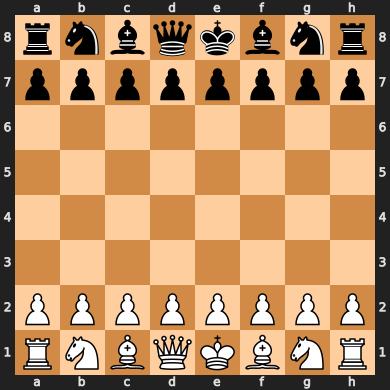

In [ ]:
#@title check board
env = PickPlaceEnv()
obs = env.reset(config)
current_board = sync_board_with_simulation(env.obj_name_to_id,
                                           PLACE_TARGETS,
                                           square_size, # Global variable for square side length
                                           verbose_sync=False) # Set to True for detailed sync logs

current_board

In [ ]:
#@title test moving
# obs = env.reset(config)
# pick_xyz = list(pybullet.getBasePositionAndOrientation(env.obj_name_to_id["white King"])[0])
# place_xyz = PLACE_TARGETS['h5']
# act = {'pick': pick_xyz, 'place': place_xyz}
# obs, _, _, _ = env.step(act)

pick_xyz = list(pybullet.getBasePositionAndOrientation(env.obj_name_to_id["black Queen"])[0])
place_xyz = PLACE_TARGETS['d2']
act = {'pick': pick_xyz, 'place': place_xyz}
obs, _, _, _ = env.step(act)


# Show video of environment rollout.
debug_clip = ImageSequenceClip(env.cache_video, fps=25)
display(debug_clip.ipython_display(autoplay=1, loop=1, center=False))
env.cache_video = []

STEP: Main move is to pick 'black Queen' from [       0.08       -0.77] and place on [       0.08       -0.26].
STEP: Target square for 'black Queen' is occupied by 'white Pawn 4'.
STEP: CAPTURE DETECTED! 'black Queen' will capture 'white Pawn 4'.
    Preparing to remove 'white Pawn 4' first.
--- Atomic P&P: Start - Remove captured 'white Pawn 4' ---
    Picking from: [      0.083      -0.257       0.031], Placing to: [      0.508      -0.215        0.02]
    Atomic: Hovering over pick at [      0.083      -0.257       0.231]
    Atomic: Lowering to grasp at [      0.083      -0.257        0.02]
    Atomic: Lifting piece to [      0.083      -0.257       0.231]
    Atomic: Moving to above place at [      0.508      -0.215        0.12]
    Atomic: Lowering to place...
    Atomic: Lifting gripper to [      0.508      -0.215        0.12]
--- Atomic P&P: End - Remove captured 'white Pawn 4' ---
    'white Pawn 4' removed from obj_name_to_id tracking after being moved off-board.
STEP: Proce

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
env.reset(config)

making the chess board


{'image': array([[[239, 239, 239],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [150, 173, 208],
         [150, 173, 208],
         [150, 173, 208]],
 
        [[  0,   0,   0],
         [153, 153, 153],
         [153, 153, 153],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ...,
 
        [[239, 239, 239],
         [239, 239, 239],
         [239, 239, 239],
         ...,
         [150, 173, 208],
         [150, 173, 208],
         [150, 173, 208]],
 
        [[239, 239, 239],
         [239, 239, 239],
         [239, 239, 239],
         ...,
         [150, 173, 208],
         [150, 173, 208],
         [150, 173, 208]],
 
        [[239, 239, 239],
         [239, 239, 239],
         [239, 239, 239],
         ...,
         [150, 173,

LLM Query: I want to move the white knight from b1 to c3. The robot command should be:

Considering 2049 options

--- Getting LLM Scores ---

--- Getting Affordance Scores ---
Base Synced Board FEN for Affordance Scoring: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w - - 0 1

--- Combining Scores ---

Selecting: robot.pick_and_place(white Knight 1, c3) (Score: 1.0000)

--- Plotting Scores ---


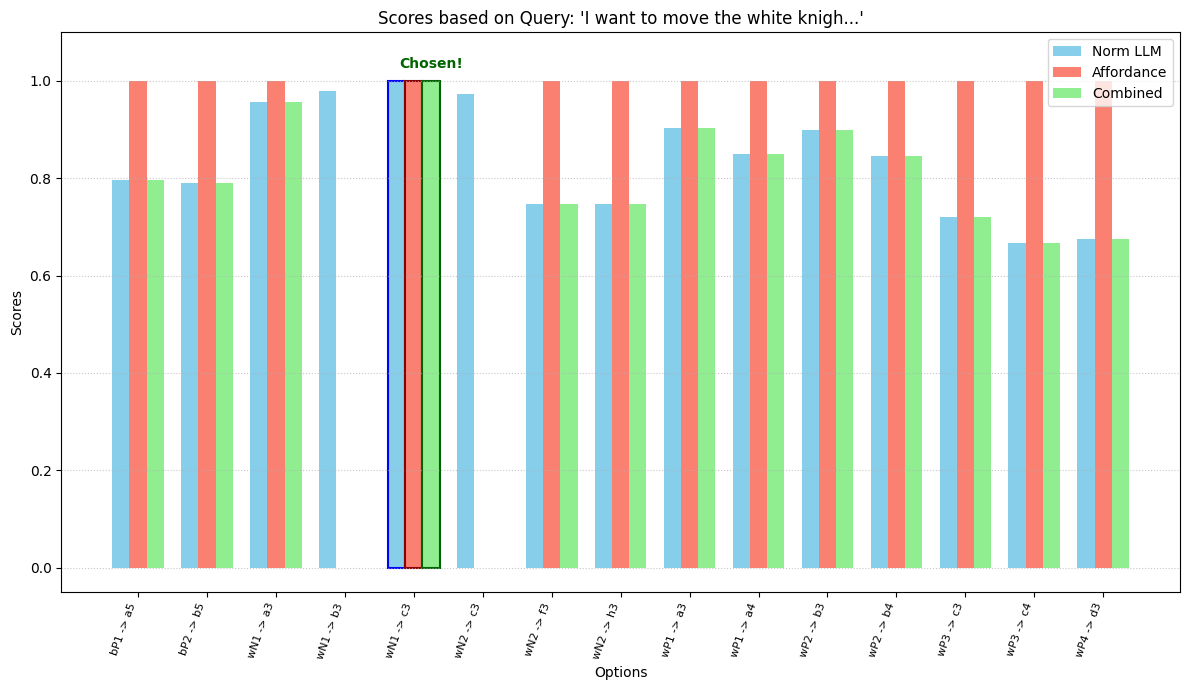


--- Executing Action: robot.pick_and_place(white Knight 1, c3) ---
STEP: Main move is to pick 'white Knight 1' from [       0.25       -0.17] and place on [       0.17       -0.34].
STEP: Proceeding with main pick and place for 'white Knight 1'.
--- Atomic P&P: Start - Main move 'white Knight 1' ---
    Picking from: [      0.253      -0.171       0.043], Placing to: [      0.168      -0.342        0.02]
    Atomic: Hovering over pick at [      0.253      -0.171       0.243]
    Atomic: Lowering to grasp at [      0.253      -0.171        0.02]
    Atomic: Lifting piece to [      0.253      -0.171       0.243]
    Atomic: Moving to above place at [      0.168      -0.342        0.12]
    Atomic: Lowering to place...
    Atomic: Lifting gripper to [      0.168      -0.342        0.12]
--- Atomic P&P: End - Main move 'white Knight 1' ---

--- Displaying Action Video ---
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4



--- Run Complete ---


In [ ]:
#@title Test

# ... (your existing config and setup for PickPlaceEnv, PICK_TARGETS, PLACE_TARGETS, square_size, etc.) ...
# ... (ensure shorten_option_label, normalize_scores, gpt3_scoring, make_options, sync_board_with_simulation are defined) ...

# --- Single Execution Example ---
# obs = env.reset(config) # Reset the environment to the initial board state
# img = env.get_camera_image()
# plt.imshow(img); plt.title("Initial Board State"); plt.show()


ENGINE = "gpt-4o-mini"
LLM_CACHE = {}
termination_string = "done()"

# --- YOUR QUERY WILL NOW DRIVE WHICH COLOR TO CONSIDER ---
# query = "To pick the white Queen and put it at d5, I should:\n"
# query = "I want to move the white Pawn from d4 to e5. The robot command should be:\n"
query = "I want to move the white knight from b1 to c3. The robot command should be:\n"

# query = "Move white King from e1 to e2. Robot command:"
print(f"LLM Query: {query}")

# 1. Make options
options = make_options(PICK_TARGETS, PLACE_TARGETS, termination_string=termination_string)
if not options:
    print("No options generated. Exiting test.")
    # exit()

commands_string_for_gpt = "\n".join(options)
commands_string_for_gpt = 'BEGIN OPTIONS AVAILABLES:\n' + commands_string_for_gpt + '\nEND OPTIONS.\n'

# 2. Get LLM Scores
print("\n--- Getting LLM Scores ---")
llm_scores, res = gpt3_scoring(query, call_law_start, commands_string_for_gpt, options, model=ENGINE, top_logprobs=5, verbose=False)
normalized_llm_scores = normalize_scores(llm_scores)

# 3. Get Affordance Scores
print("\n--- Getting Affordance Scores ---")
# Sync the chess.Board with the current simulation state.
# The .turn property of this board will be its default (White) or based on last FEN if you load one.
# But affordance_scoring will override it per-option.
base_synced_board = sync_board_with_simulation(env.obj_name_to_id,
                                           PLACE_TARGETS,
                                           square_size,
                                           verbose_sync=False)
print(f"Base Synced Board FEN for Affordance Scoring: {base_synced_board.fen()}")
# Note: base_synced_board.turn might show White, but affordance_scoring will adjust locally.

affordance_scores = affordance_scoring(options,
                                       env.obj_name_to_id,
                                       base_synced_board, # Pass the board representing physical state
                                       PLACE_TARGETS,
                                       square_size,
                                       verbose=False, # Enable for detailed affordance logs
                                       termination_string=termination_string)

# 4. Combine Scores
print("\n--- Combining Scores ---")
combined_scores = {}
for option_str_cs, llm_score_val_cs in normalized_llm_scores.items():
    if option_str_cs in affordance_scores:
        affordance_score_val_cs = affordance_scores[option_str_cs]
        combined_scores[option_str_cs] = llm_score_val_cs * affordance_score_val_cs
    # else:
    #     combined_scores[option_str_cs] = 0

# 5. Select the best action
selected_task = None
if combined_scores:
    positive_combined_scores = {k: v for k, v in combined_scores.items() if v > 0}
    if positive_combined_scores:
        selected_task = max(positive_combined_scores, key=positive_combined_scores.get)
        print(f"\nSelecting: {selected_task} (Score: {positive_combined_scores[selected_task]:.4f})")
    else:
        print(f"\nNo options with a positive combined score available.")
        # Fallback for debugging: pick highest LLM score that had *any* positive raw affordance
        fallback_candidates = {}
        for opt_fb, llm_s_fb in normalized_llm_scores.items():
             if opt_fb in affordance_scores and affordance_scores[opt_fb] > 0:
                 fallback_candidates[opt_fb] = llm_s_fb
        if fallback_candidates:
            selected_task = max(fallback_candidates, key=fallback_candidates.get)
            print(f"FALLBACK SELECTION: {selected_task} (LLM Norm Score: {fallback_candidates[selected_task]:.4f}, Affordance: {affordance_scores.get(selected_task)})")

else:
    print("\nNo combined scores calculated.")



# 6. Execute the chosen action (if any)
if selected_task and selected_task != termination_string:
    print(f"\n--- Executing Action: {selected_task} ---")
    try:
        action_parts = selected_task.split('(')[1].split(')')[0].split(',')
        piece_to_pick_name = action_parts[0].strip()
        target_square_name = action_parts[1].strip()

        if piece_to_pick_name not in env.obj_name_to_id:
            print(f"ERROR: Piece '{piece_to_pick_name}' not found in simulation. Cannot execute.")
        elif target_square_name not in PLACE_TARGETS:
            print(f"ERROR: Target square '{target_square_name}' not found in PLACE_TARGETS. Cannot execute.")
        else:
            pick_xyz_coords = list(pybullet.getBasePositionAndOrientation(env.obj_name_to_id[piece_to_pick_name])[0])
            place_xyz_coords = PLACE_TARGETS[target_square_name]
            act_to_perform = {'pick': pick_xyz_coords, 'place': place_xyz_coords}
            obs, _, _, _ = env.step(act_to_perform)

            if env.cache_video:
                print("\n--- Displaying Action Video ---")
                debug_clip = ImageSequenceClip(env.cache_video, fps=25)
                display(debug_clip.ipython_display(autoplay=1, loop=0, center=False))
                env.cache_video = []
    except Exception as e:
        print(f"Error executing action '{selected_task}': {e}")
        import traceback
        traceback.print_exc()
elif selected_task == termination_string:
    print("\nTermination action 'done()' selected.")
else:
    print("\nNo valid action selected to execute.")

print("\n--- Run Complete ---")